In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_text as text

In [2]:
import tensorflow_hub as hub

In [3]:
factoid = pd.read_pickle("/app/home/heindlc/reddit_corpus_balanced_filtered.gzip", compression = "gzip")

In [4]:
factoid["pb_factor"].isnull().sum()

74

In [5]:
factoid = factoid[~ factoid["pb_factor"].isnull()]

In [6]:
factoid["pb_factor"].isnull().sum()

0

In [7]:
data = pd.concat([pd.DataFrame([[row[1], post[1],post[3], row[-4]] for post in row[3]], columns=["user_id", "post","topic","user_pb"])
                  for row in factoid.itertuples()], ignore_index=True)


In [8]:
data.shape


(3342802, 4)

In [9]:
data.head(1)

,user_id,post,topic,user_pb
0,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,The fact that this has to be explained is what...,r/politics,-0.826087


In [10]:
data_cats = data.copy()
data_cats["pb_categories"] = pd.cut(data_cats["user_pb"],
       [-3,-1.5,0,1.5,3], include_lowest=True,labels=["EXTREME_LEFT", "LEFT_CENTER","RIGHT_CENTER","EXTREME_RIGHT"])
data_cats

,user_id,post,topic,user_pb,pb_categories
0,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,The fact that this has to be explained is what...,r/politics,-0.826087,LEFT_CENTER
1,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,"he's not deteriorating, he just does not care ...",r/politics,-0.826087,LEFT_CENTER
2,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,"Look, it's now perfectly clear that if he coul...",r/politics,-0.826087,LEFT_CENTER
3,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,That's the whole point of this statement. Ther...,r/politics,-0.826087,LEFT_CENTER
4,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,"I keep seeing that M4A is now just a ""bargaini...",r/politics,-0.826087,LEFT_CENTER
...,...,...,...,...,...
3342797,265bde26afcab547a099f352a67bc462851b3d8b1b588c...,"They should say yes, that the debate is back o...",r/politics,-0.777778,LEFT_CENTER
3342798,265bde26afcab547a099f352a67bc462851b3d8b1b588c...,Oil prices is so low... how is this even profi...,r/politics,-0.777778,LEFT_CENTER
3342799,265bde26afcab547a099f352a67bc462851b3d8b1b588c...,No he wants to win to avoid prison and those c...,r/politics,-0.777778,LEFT_CENTER
3342800,265bde26afcab547a099f352a67bc462851b3d8b1b588c...,Obviously this is why we need a federal level ...,r/Coronavirus,-0.777778,LEFT_CENTER


/app/home/heindlc/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pb_categories', ylabel='count'>

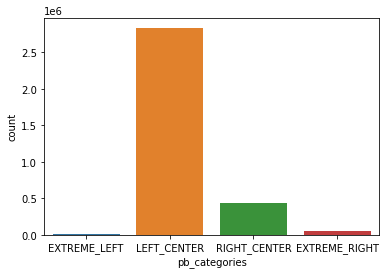

In [11]:
sns.countplot('pb_categories', data=data_cats)

In [12]:
class_counts = data_cats.pb_categories.value_counts()

c4 = data_cats[data_cats['pb_categories'] == "LEFT_CENTER"]
c3 = data_cats[data_cats['pb_categories'] == "RIGHT_CENTER"]
c2 = data_cats[data_cats['pb_categories'] == "EXTREME_LEFT"]
c1 = data_cats[data_cats['pb_categories'] == "EXTREME_RIGHT"]

In [13]:
class_counts

LEFT_CENTER      2836082
RIGHT_CENTER      440683
EXTREME_RIGHT      48958
EXTREME_LEFT       17079
Name: pb_categories, dtype: int64

In [14]:
c3 = c3.sample(class_counts["EXTREME_RIGHT"])   
c4 = c4.sample(class_counts["EXTREME_LEFT"])
data_balanced = pd.concat([c1,c2,c3,c4],axis=0 )

/app/home/heindlc/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pb_categories', ylabel='count'>

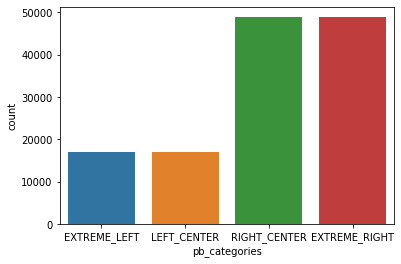

In [15]:
sns.countplot('pb_categories', data=data_balanced)

In [16]:
def binaryfy(label):
    if label in ["EXTREME_LEFT","EXTREME_RIGHT"]:
        return "EXTREME"
    else: 
        return "MODERATE"

In [17]:
data_binary = data_balanced.copy()
#df["Labels"] = df["Score"].apply(lambda score: map_score(score))
data_binary["pb_binary"] = data_binary["pb_categories"].apply(lambda label: binaryfy(label))

/app/home/heindlc/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pb_binary', ylabel='count'>

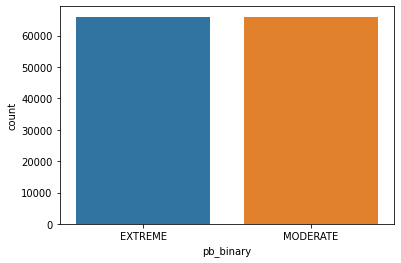

In [18]:
sns.countplot('pb_binary', data=data_binary)

In [19]:
# export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

In [20]:
! python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

/bin/bash: /app/home/heindlc/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


In [21]:

preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4",
    trainable=True)

2022-05-28 13:31:13.228043: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-28 13:31:14.845229: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38418 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2022-05-28 13:31:14.847241: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38418 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:61:00.0, compute capability: 8.0
2022-05-28 13:31:14.849061: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/devi

In [25]:
data_binary.head(3)

,user_id,post,topic,user_pb,pb_categories,pb_binary
61426,a76ed6c4f319b018700503a50c333028384bf7e9976796...,Biden is a horrible man. Straight up lying to...,r/Republican,3.0,EXTREME_RIGHT,EXTREME
61427,a76ed6c4f319b018700503a50c333028384bf7e9976796...,"The media,FBI, and the big banks, work for the...",r/Republican,3.0,EXTREME_RIGHT,EXTREME
61428,a76ed6c4f319b018700503a50c333028384bf7e9976796...,#NIGHTMARES,r/Republican,3.0,EXTREME_RIGHT,EXTREME


In [53]:
tf_data = data_binary[["post", "pb_binary"]]

In [54]:
tf_data = tf.convert_to_tensor(tf_data)


In [66]:
tf_data


<tf.Tensor: shape=(132074, 2), dtype=string, numpy=
array([[b'Biden is a horrible man.  Straight up lying to the Americans. What a clown.',
        b'EXTREME'],
       [b'The media,FBI, and the big banks, work for the \xe2\x80\x9cbig guy\xe2\x80\x9d.  Nothing will happen. One big corrupt filthy family. Mexico\xe2\x80\x99s government seems like saints compared to these people.',
        b'EXTREME'],
       [b'#NIGHTMARES', b'EXTREME'],
       ...,
       [b'I think you underestimate the anger about what Republicans did to the country.',
        b'MODERATE'],
       [b"By my understanding, they could have just responded to the narrow question of whether or not the campaign could amend their complaint. Instead, they took the time to shoot down every single aspect of the case.  It's lunacy that conservatives are trying to spin this as a good result.",
        b'MODERATE'],
       [b"They have Cohen's testimony.", b'MODERATE']], dtype=object)>

In [40]:
tf_data

,post,pb_binary
61426,Biden is a horrible man. Straight up lying to...,EXTREME
61427,"The media,FBI, and the big banks, work for the...",EXTREME
61428,#NIGHTMARES,EXTREME
61429,That’s not even the bad video. Gnews.org is re...,EXTREME
61430,Wish the FBI would too. So much ignored corrup...,EXTREME
...,...,...
1325547,&gt;U.S. President Donald Trump is unlikely to...,MODERATE
1026990,Dan Patrick is a straight up lunatic. He’s sti...,MODERATE
3173149,I think you underestimate the anger about what...,MODERATE
1525903,"By my understanding, they could have just resp...",MODERATE


In [76]:
Post

['Biden is a horrible man.  Straight up lying to the Americans. What a clown.',
 'The media,FBI, and the big banks, work for the “big guy”.  Nothing will happen. One big corrupt filthy family. Mexico’s government seems like saints compared to these people.',
 '#NIGHTMARES',
 'That’s not even the bad video. Gnews.org is releasing tons of stuff. I don’t know anything about that site, but if it’s true, I’m going to be sick. They just write about some of the other videos.',
 'Wish the FBI would too. So much ignored corruption.',
 'This is another democrat lie. The police have no record of this lady, and she was never posted on his Twitter. He sent a letter to the weekly.  https://mobile.twitter.com/mrandyngo/status/1306384956822704130  And they continue to blame Trump for Covid, but they lie about that as well. They ignored his plea for a quarantine. https://ibb.co/2qVbgWJ',
 'If they’re capable of reading non bias regurgitated Twitter quotes, they should read this- https://frankreport.com

In [78]:
tf_data = data_binary[["post", "pb_binary"]]
target = tf_data.pop("pb_binary")


#Post,labels = list(train["post"]), list(train.pop("pb_binary"))
#dataset = tf.data.Dataset.from_tensor_slices(Post, labels)


dataset = tf.data.Dataset.from_tensor_slices((tf_data.values, target.values))


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')  # shape definition ? () = none ?
    preprocessing_layer = hub.KerasLayer(preprocessor, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [ ]:
text_test = data["posts"][1:3]
text_test

In [ ]:
classifier_model = build_classifier_model()
